In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from itertools import chain, combinations
import operator
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Cargar datos

In [2]:
datos_category=pd.read_excel('Base de datos prueba tecnica.xlsx', sheet_name='DB')
variables=pd.read_excel('Base de datos prueba tecnica.xlsx', sheet_name='DB')



# Ingeniería de características

## Valores nulos

In [3]:
datos_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19942 entries, 0 to 19941
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   REGIONAL                   19942 non-null  object 
 1   DEPARTAMENTO               19942 non-null  object 
 2   TECNOL                     19942 non-null  object 
 3   GERENCIA                   19942 non-null  object 
 4   CANAL_HOMOLOGADO_MILLICON  19942 non-null  object 
 5   tipo_fuerza_venta          19942 non-null  object 
 6   estrato                    19942 non-null  object 
 7   antiguedad_meses           18264 non-null  float64
 8   productos                  19942 non-null  object 
 9   portafolio                 19942 non-null  object 
 10  no_serv_tecnicos           6909 non-null   float64
 11  fallo                      6909 non-null   object 
 12  asesoria_factura           19942 non-null  int64  
 13  pedidos_peticiones         19942 non-null  int

Las columnas  antiguedad_meses, no_serv_tecnicos, fallo tienen valores nulos con los cuales lidiaremos de la siguiente manera.

* Para la antigüedad en meses vamos a utilizar la media de cada grupo e.g. si una fila del grupo de no pago tiene antigüedad en meses nula vamos a  reemplazar ese valor nulo por la media de antigüedades en el grupo de no pago.

* Los valores nulos de la columna no_serv_tecnicos los reemplazaremos con 0
* Los valores nulos de la columna fallo los reemplazaremos con el valor sin_fallos

In [4]:
datos_category['no_serv_tecnicos']=datos_category['no_serv_tecnicos'].fillna(0)

datos_category['fallo']=datos_category['fallo'].fillna('sin_fallos')   





In [5]:
m1=datos_category[datos_category['Incumplimiento_pago']==1]['antiguedad_meses'].median()
m0=datos_category[datos_category['Incumplimiento_pago']==0]['antiguedad_meses'].median()

datos_category['antiguedad_meses']=np.where(datos_category['Incumplimiento_pago']==1,datos_category['antiguedad_meses'].fillna(m1),datos_category['antiguedad_meses'].fillna(m0))

In [6]:
datos_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19942 entries, 0 to 19941
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   REGIONAL                   19942 non-null  object 
 1   DEPARTAMENTO               19942 non-null  object 
 2   TECNOL                     19942 non-null  object 
 3   GERENCIA                   19942 non-null  object 
 4   CANAL_HOMOLOGADO_MILLICON  19942 non-null  object 
 5   tipo_fuerza_venta          19942 non-null  object 
 6   estrato                    19942 non-null  object 
 7   antiguedad_meses           19942 non-null  float64
 8   productos                  19942 non-null  object 
 9   portafolio                 19942 non-null  object 
 10  no_serv_tecnicos           19942 non-null  float64
 11  fallo                      19942 non-null  object 
 12  asesoria_factura           19942 non-null  int64  
 13  pedidos_peticiones         19942 non-null  int

Ahora partimos nuestro conjunto de datos en datos de entrenamiento y de prueba para los algoritmos a aplicar

In [7]:
train, test = train_test_split(datos_category, test_size=0.2)



Primero analizamos qué paricipación en los datos tienen los grupos qué queremos calificar


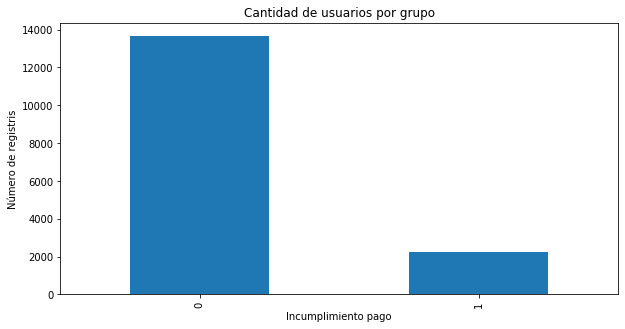

In [8]:
fig,ax=plt.subplots(figsize=(10,5))
ax.set_xlabel('Incumplimiento pago')
ax.set_ylabel('Número de registris')
ax.set_title('Cantidad de usuarios por grupo')
train['Incumplimiento_pago'].value_counts().plot(kind='bar',ax=ax)

Ahora vemos cómo está compuesto cada grupo bajo distintos criterios

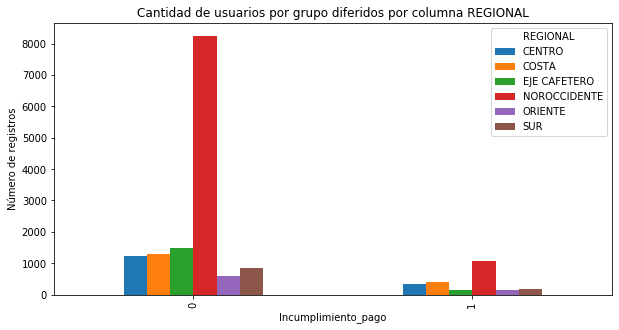

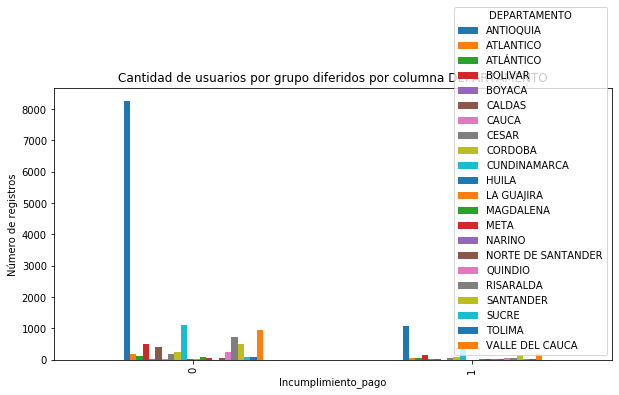

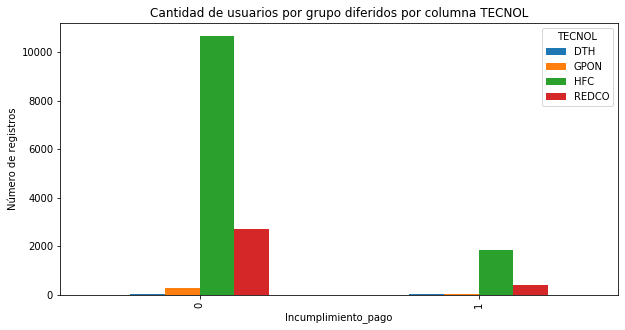

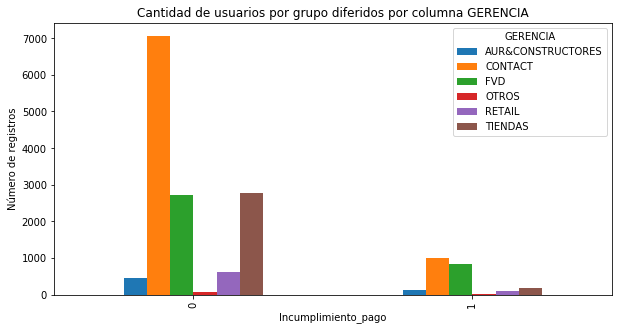

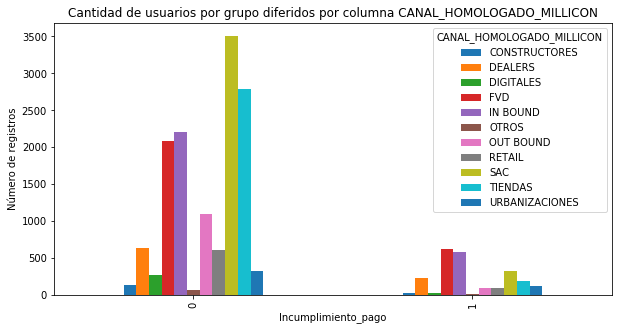

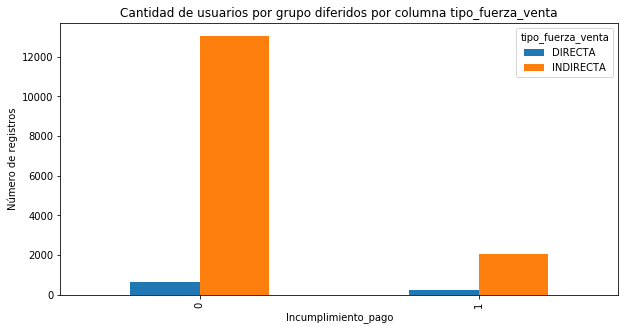

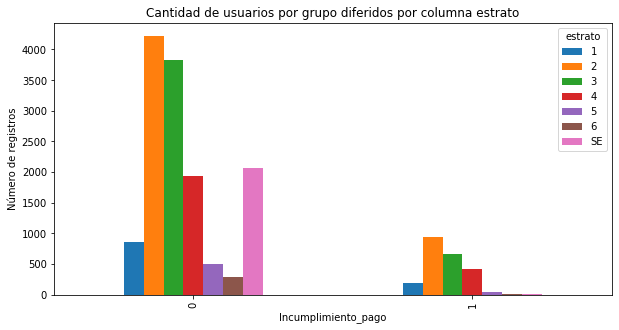

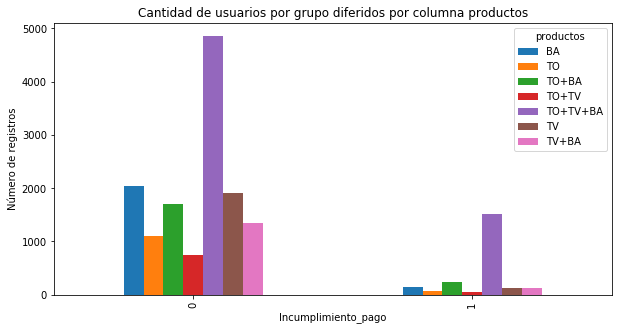

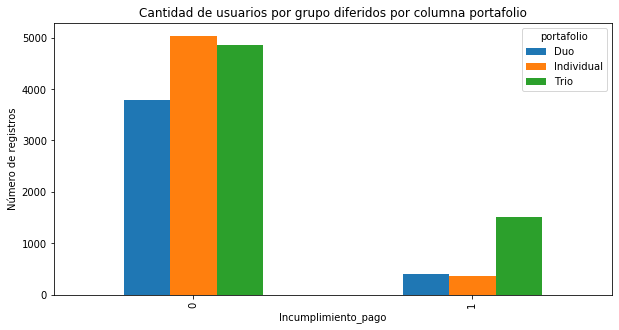

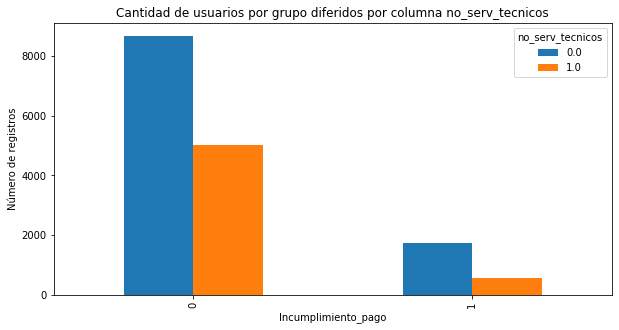

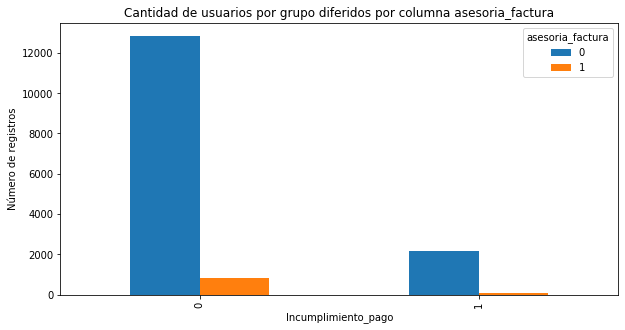

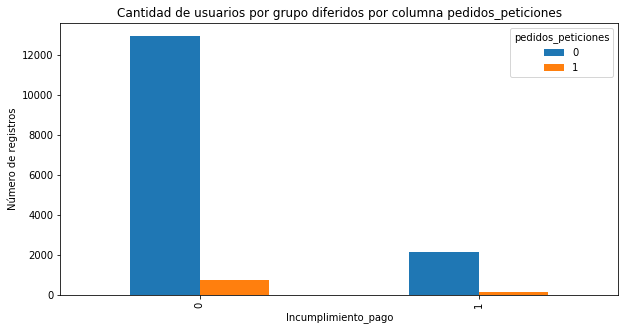

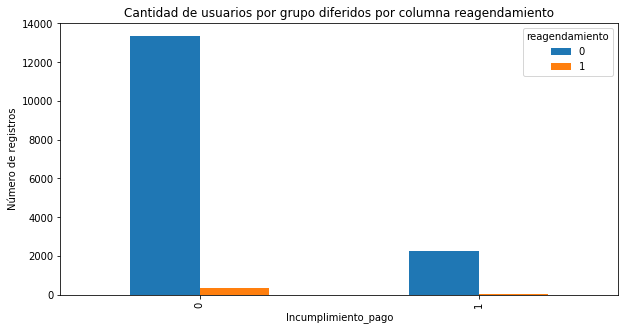

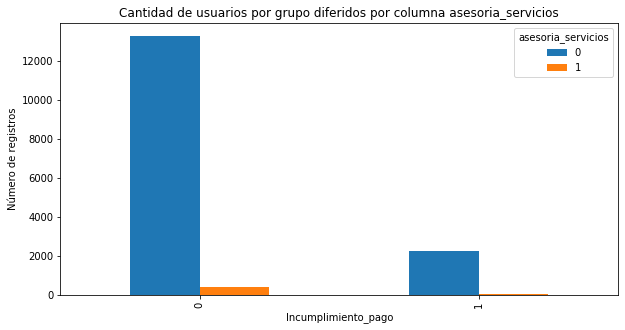

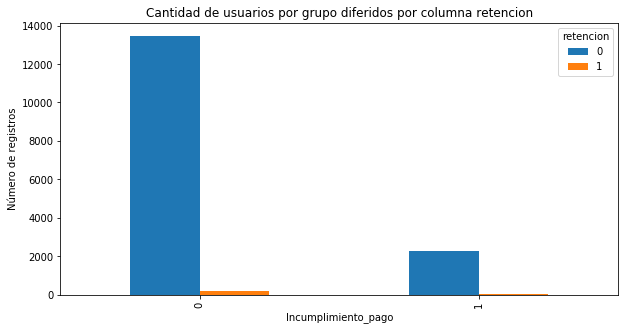

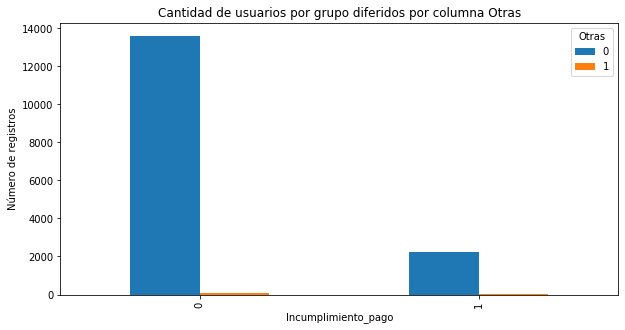

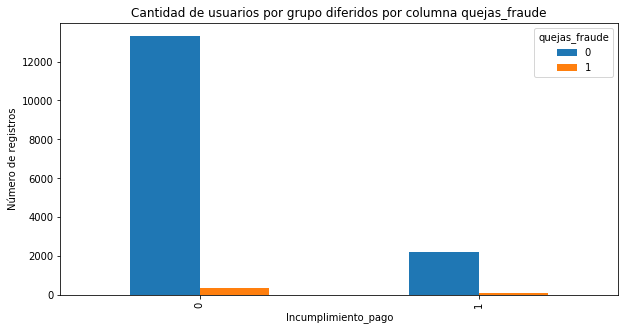

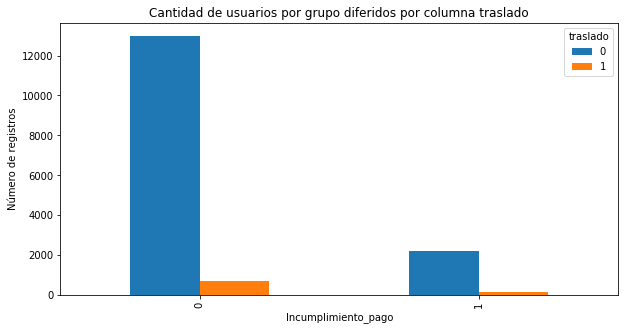

In [9]:
for columna in train.drop(columns=['Incumplimiento_pago', 'cliente_id','antiguedad_meses','fallo']).columns:
    fig,ax=plt.subplots(figsize=(10,5))
    ax.set_xlabel('Incumplimiento pago')
    ax.set_ylabel('Número de registros')
    ax.set_title('Cantidad de usuarios por grupo diferidos por columna {columna}'.format(columna=columna))
    data=train[['Incumplimiento_pago',columna]]
    data.groupby(['Incumplimiento_pago',columna]).size().unstack().plot(kind='bar',ax=ax)

Como el tamaño de los grupos no es uniforme en el conjunto de datos, es importante el análisis anterior pero con frecuencia relativa 

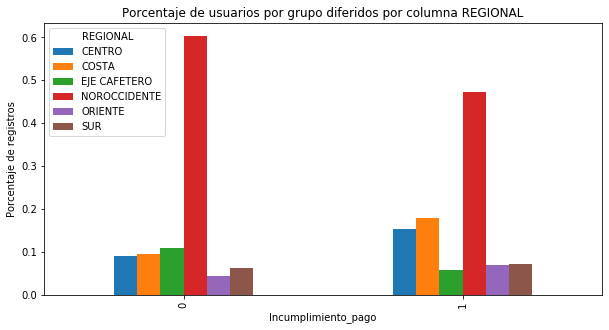

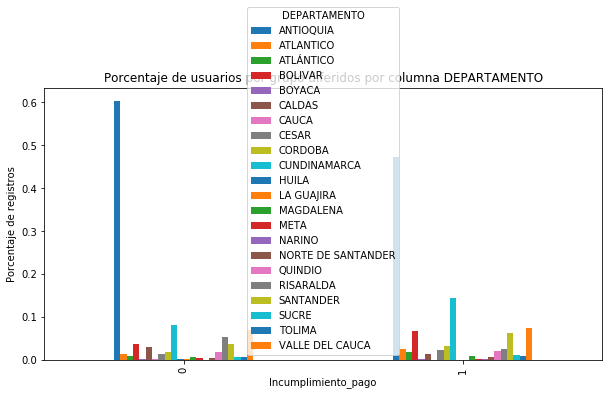

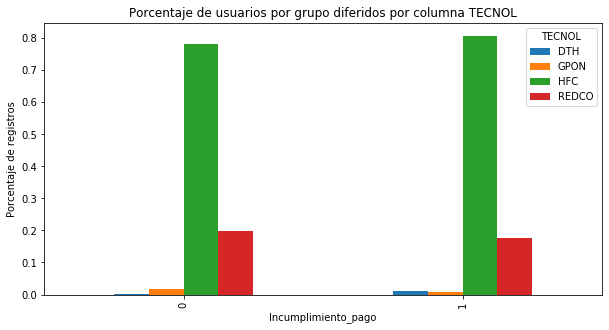

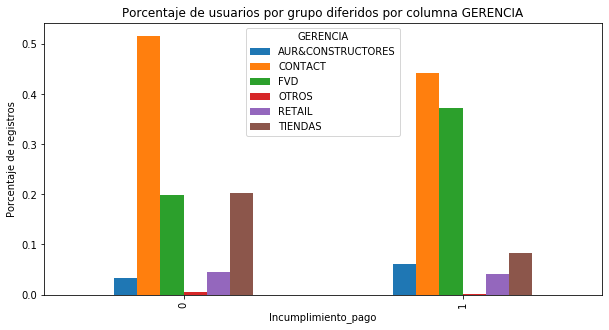

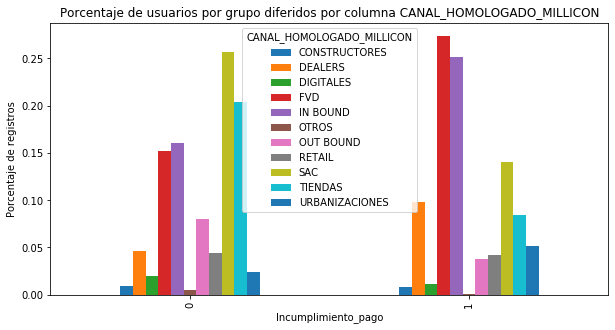

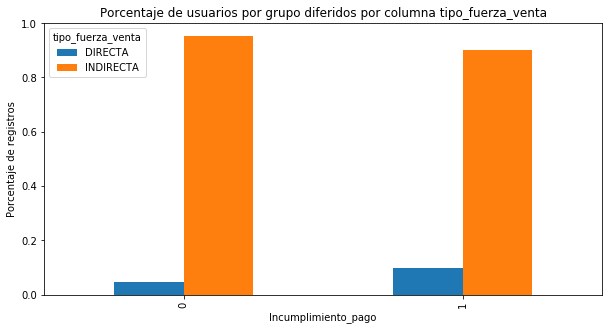

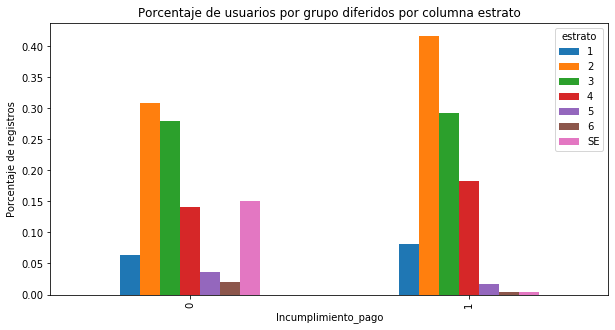

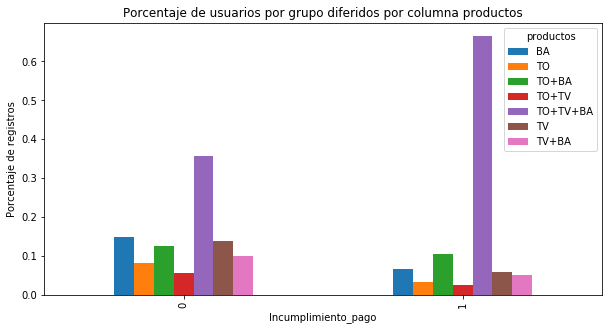

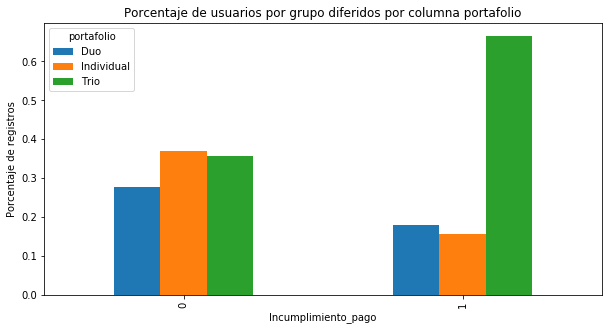

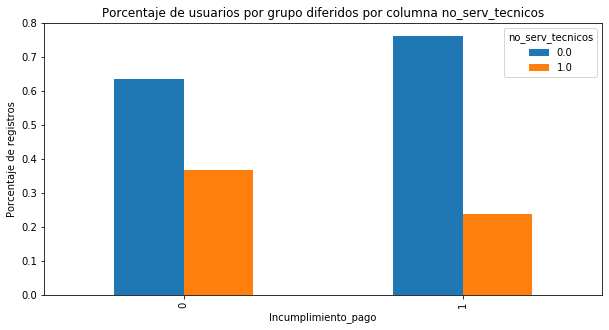

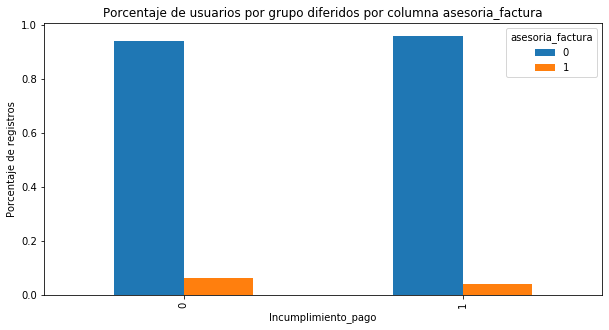

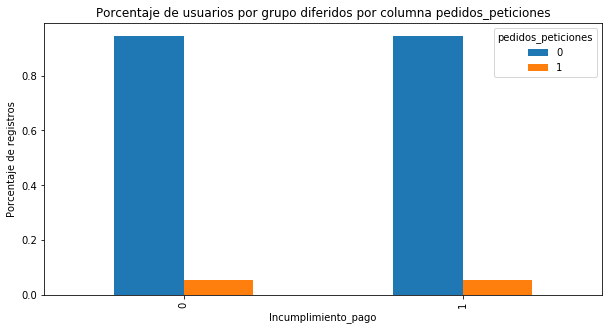

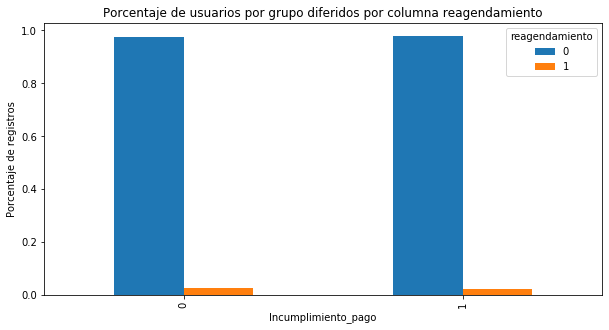

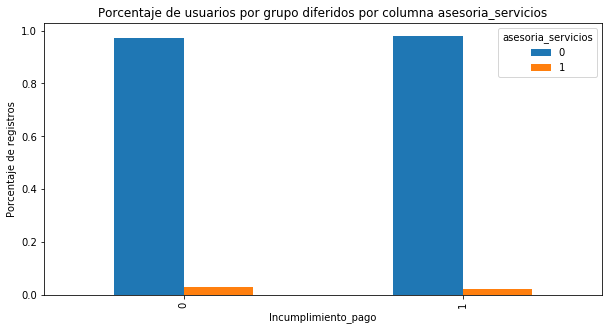

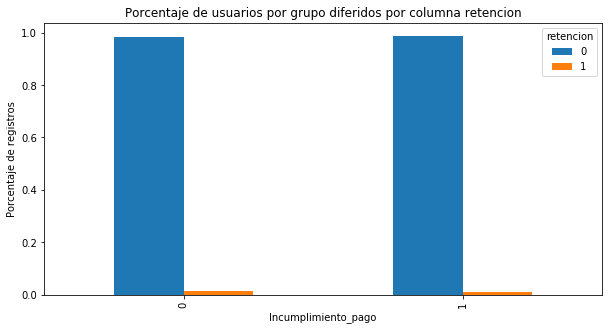

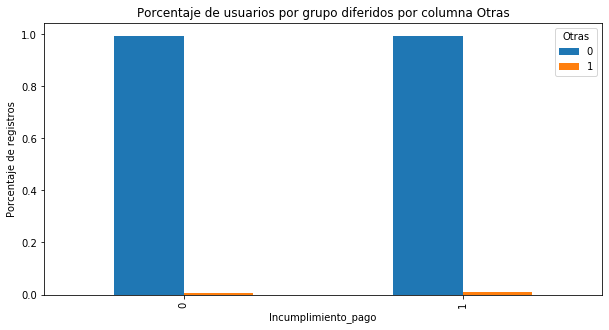

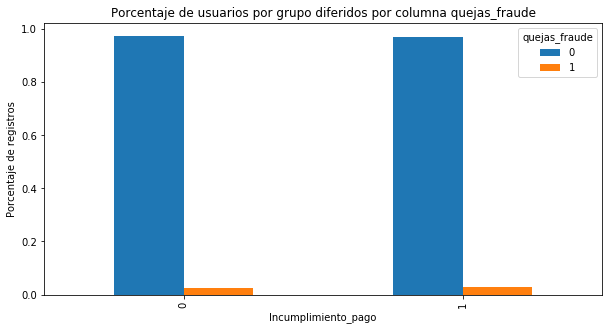

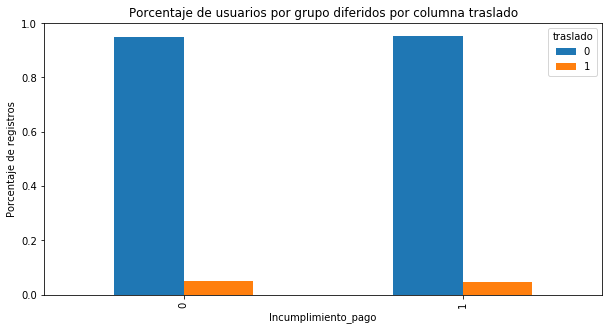

In [10]:
for columna in train.drop(columns=['Incumplimiento_pago', 'cliente_id','antiguedad_meses','fallo']).columns:
    fig,ax=plt.subplots(figsize=(10,5))
    ax.set_xlabel('Incumplimiento pago')
    ax.set_ylabel('Porcentaje de registros')
    ax.set_title('Porcentaje de usuarios por grupo diferidos por columna {columna}'.format(columna=columna))
    data=train[['Incumplimiento_pago',columna]]
    c=data.groupby(['Incumplimiento_pago',columna]).size().unstack()
    c['total']=c.sum(axis=1)
    for col in c.columns:
        c[col]=c[col]/c['total']
    c=c.drop(columns=['total'])
    c.plot(kind='bar',ax=ax)

A parte vamos a ver las variables que no se ajustaban tan bien al tipo de gráfica anterior

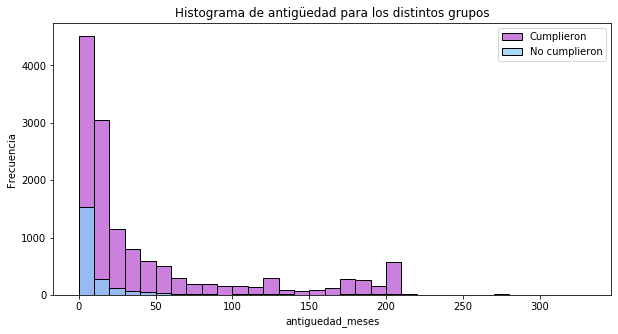

In [11]:
fig,ax=plt.subplots(figsize=(10,5))


ax.set_ylabel('Frecuencia')
ax.set_title('Histograma de antigüedad para los distintos grupos')

columna='antiguedad_meses'
data=train[['Incumplimiento_pago',columna]]
a,b=data[data['Incumplimiento_pago']==1],data[data['Incumplimiento_pago']==0]
sns.histplot(data=b, x=columna, bins=np.arange(0, max([b[columna].max(),a[columna].max()]), 10), color="mediumorchid", ax=ax)
sns.histplot(data=a, x=columna, bins=np.arange(0,  max([b[columna].max(),a[columna].max()]), 10), color="lightskyblue", ax=ax)
ax.legend(['Cumplieron','No cumplieron'])

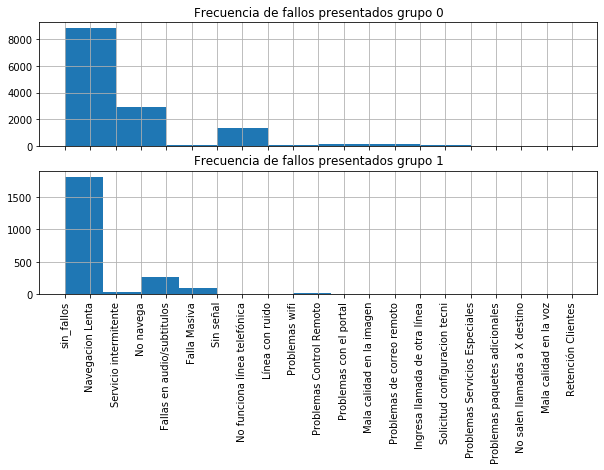

In [12]:
fig,(ax0,ax1)=plt.subplots(nrows=2,figsize=(10,5),sharex=True)
ax0.set_title('Frecuencia de fallos presentados grupo 0')
ax1.set_title('Frecuencia de fallos presentados grupo 1')


columna='fallo'
data=train[['Incumplimiento_pago',columna]]
a1,a0=data[data['Incumplimiento_pago']==1],data[data['Incumplimiento_pago']==0]

a1[columna].hist(ax=ax1,xrot=90)


a0[columna].hist(ax=ax0,xrot=90)


## Conclusiones del análisis exploratorio

A continuación se encuentran conclusiones sobre la influencia de cada variable en la determinación para calificar  a un usaurio basado en lo observado en el análisis exploratorio:

* 'REGIONAL' 
   
     No es marcamente diferenciada entre los grupos 
     pero graficamente no es posible diferenciar si es posible descartarla

   
* 'DEPARTAMENTO'

   No es marcamente diferenciada entre los grupos 
     pero graficamente no es posible diferenciar si es posible descartarla

* 'TECNOL' 
    No es marcamente diferenciada entre los grupos 
     pero graficamente no es posible diferenciar si es posible descartarla
    
* 'GERENCIA'
   
   Es más diferenciada entre las dos etiquetas. Es posible que sea determinate para clasificar.

* 'CANAL_HOMOLOGADO_MILLICON'

    La diferencia de esta variable entre ambos grupos es muy marcada y posiblemente también sea determinante
    en el análisis

* 'tipo_fuerza_venta' 
    Con toda certeza esta variable no va a ser determinante porque tiene el mismo comportamiento en ambos grupos
    
* 'estrato' 

   Esta variable es diferenciada entre los dos grupos aunque no marcadamente.

* 'antiguedad_meses'

    Esta variable es marcadamente diferenciada entre ambos grupos


* 'productos'

   Esta variable es marcadamente diferenciada entre ambos grupos

* 'portafolio' 

* 'no_serv_tecnicos'

    No presenta diferencia entre los grupos y por lo tanto no va a ser relevante
       
* 'fallo' 
    
   Esta variable es marcadamente difrenciada entre ambos grupos
    
* 'asesoria_factura'
    
   Con toda certeza esta variable no va a ser determinante porque tiene el mismo comportamiento en ambos grupos


* 'pedidos_peticiones' 
   
   Con toda certeza esta variable no va a ser determinante porque tiene el mismo comportamiento en ambos grupos
   
* 'reagendamiento'
   
   Con toda certeza esta variable no va a ser determinante porque tiene el mismo comportamiento en ambos grupos
   
* 'asesoria_servicios' 

    Con toda certeza esta variable no va a ser determinante porque tiene el mismo comportamiento en ambos grupos

* 'retencion'
    Con toda certeza esta variable no va a ser determinante porque tiene el mismo comportamiento en ambos grupos.
   
    
* 'Otras'
    Con toda certeza esta variable no va a ser determinante porque tiene el mismo comportamiento en ambos grupos
* 'quejas_fraude' 
   Con toda certeza esta variable no va a ser determinante porque tiene el mismo comportamiento en ambos grupos


* 'traslado'
  Con toda certeza esta variable no va a ser determinante porque tiene el mismo comportamiento en ambos grupos


In [13]:
variablesADescartar=['no_serv_tecnicos','asesoria_factura', 'pedidos_peticiones', 'reagendamiento',
       'asesoria_servicios', 'retencion', 'Otras', 'quejas_fraude', 'traslado', 'tipo_fuerza_venta']
datos_category=datos_category.drop(columns=variablesADescartar)

# Regrsión Logística

Vamos a implementar una regresión logística utilizando todos los parámetros. Elegimos este modelo de clasificación porque este de hecho es una regrresión lineal de la probabilidad de que cada usuario pertenezca a un grupo determinado.

In [14]:
catVars=datos_category.drop(columns=['cliente_id','Incumplimiento_pago','antiguedad_meses']).columns
dummiesTemp=pd.get_dummies(datos_category[['cliente_id']+list(catVars)], prefix=columna)
dataLearn=dummiesTemp.merge(datos_category[['cliente_id','Incumplimiento_pago','antiguedad_meses']], how='left',on='cliente_id').drop_duplicates(subset='cliente_id')    
    

In [15]:
Xtrain, Xtest,Ytrain, Ytest = train_test_split(dataLearn.drop(columns=['Incumplimiento_pago','cliente_id']),dataLearn['Incumplimiento_pago'], test_size=0.2)

logreg = LogisticRegression(fit_intercept=False)
logreg.fit(Xtrain,Ytrain)

y_pred = logreg.predict(Xtest)

print('Porcentaje de aciertos en el test: {aciertos}'.format(aciertos=round(logreg.score(Xtest, Ytest),1)))
print('Porcentaje de aciertos en el train: {aciertos}'.format(aciertos=round(logreg.score(Xtrain, Ytrain),1)))

Porcentaje de aciertos en el test: 0.9
Porcentaje de aciertos en el train: 0.9


/Users/nicolasbetancourt/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [16]:
probas=logreg.predict_proba(dataLearn.drop(columns=['Incumplimiento_pago','cliente_id']))

prediccion=logreg.predict(dataLearn.drop(columns=['Incumplimiento_pago','cliente_id']))


dataLearn['probabilidadPago'],dataLearn['probabilidadNoPago']=probas[:,0],probas[:,1]
dataLearn['prediccion']=prediccion

Para determinar el corte que determina a qué grupo de estrategia pertenece cada cliente analizaremos las probabilidades de cada grupo y vamos a contar los falsos psitivos

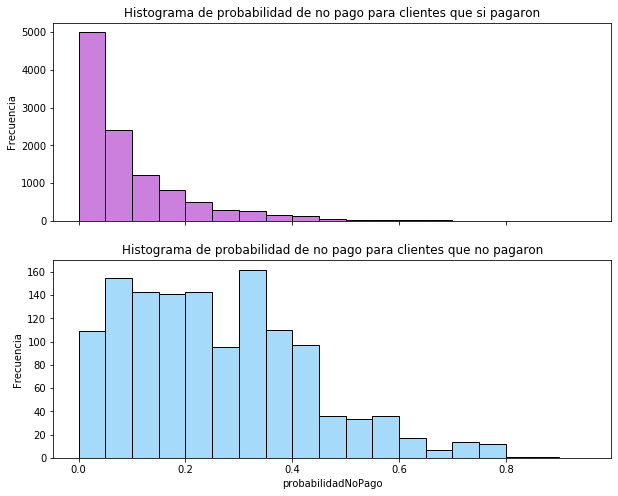

In [17]:
fig,(ax0,ax1)=plt.subplots(nrows=2,figsize=(10,8),sharex=True)


ax0.set_ylabel('Frecuencia')
ax1.set_ylabel('Frecuencia')

ax1.set_title('Histograma de probabilidad de no pago para clientes que no pagaron')
ax0.set_title('Histograma de probabilidad de no pago para clientes que si pagaron')

columna='probabilidadNoPago'
data=dataLearn[['Incumplimiento_pago',columna]]
a1,a0=data[data['Incumplimiento_pago']==1],data[data['Incumplimiento_pago']==0]
sns.histplot(data=a0, x=columna, bins=np.arange(0, 1, 0.05), color="mediumorchid", ax=ax0)
sns.histplot(data=a1, x=columna, bins=np.arange(0, 1,0.05 ), color="lightskyblue", ax=ax1)


La precisión del modelo es la capacidad que tiene para no errar al decir que un cliente no va a pagar la factura.

Por otro el recall del modelo es la capacidad del modelo de encontrar clientes que no van a clasificar su factura.


Elegir una probabilidad a partir de la cual clasificamos un cliente como con probabilidad baja de no pago, implica fijar un nivel de precisión y de recall del modelo. Vamos a elegir la probabilidad para la cual las curvas de precisión y recall se intersectan como límite a partir del cual un cliente se considera con probabilidad media de baja de no pago. Medio riesgo va a ser probabilidad del 50% pues esta nos dio una SCORE  del 90% en las pruebas anteriores. Finalmente nuestro nivel de riesgo alto va a ser el mínimo nível de probabilidad que me de una precisión del 80%.

(0, 1)

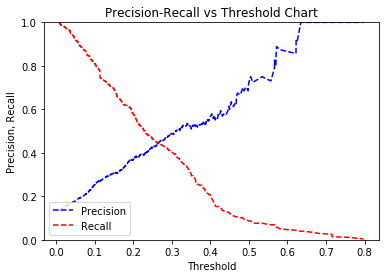

In [18]:
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
#The recall is intuitively the ability of the classifier to find all the positive samples.
pred_y=logreg.predict(Xtest) 

probs_y=logreg.predict_proba(Xtest) 
# probs_y is a 2-D array of probability of being labeled as 0 (first 
#column of 
#array) vs 1 (2nd column in array)
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(Ytest, probs_y[:, 
1]) 
#retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [19]:
nivelBajo=thresholds[precision[: -1]==recall[: -1]]
nivelMedio=0.5
nivelAlto=min(thresholds[precision[: -1]>=0.8])

## Clientes con alto riesgo de no pago

In [20]:
altoRiesgo=dataLearn[dataLearn['probabilidadNoPago']>nivelAlto]['cliente_id']
dfAltoRiesgo=datos_category[datos_category['cliente_id'].isin(altoRiesgo)]

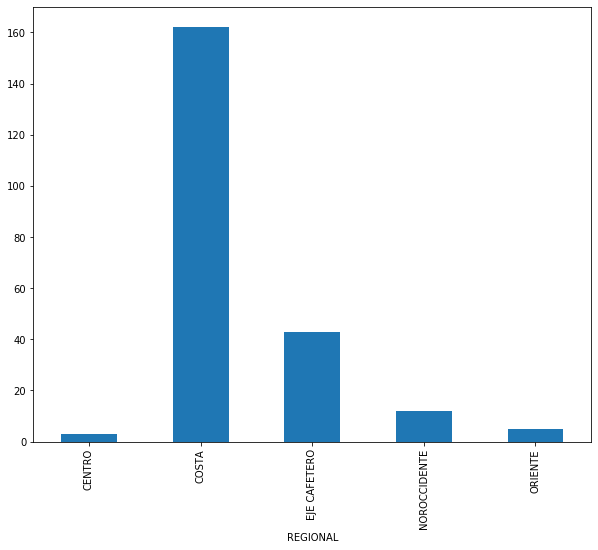

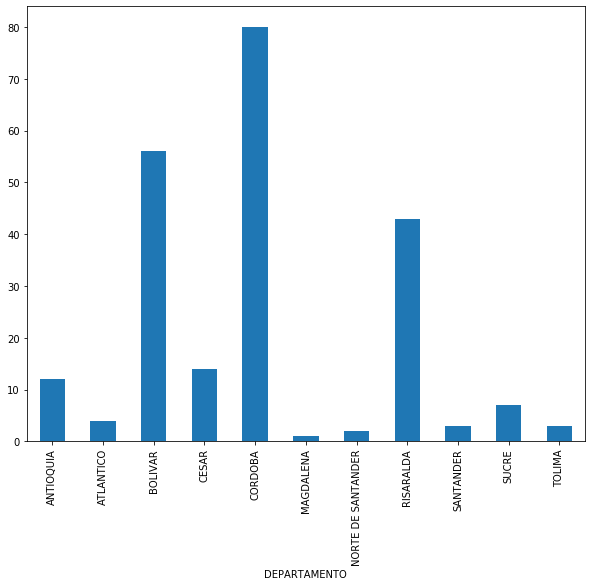

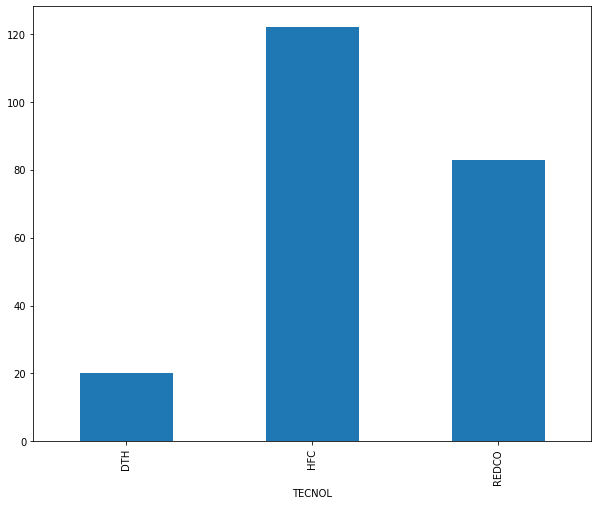

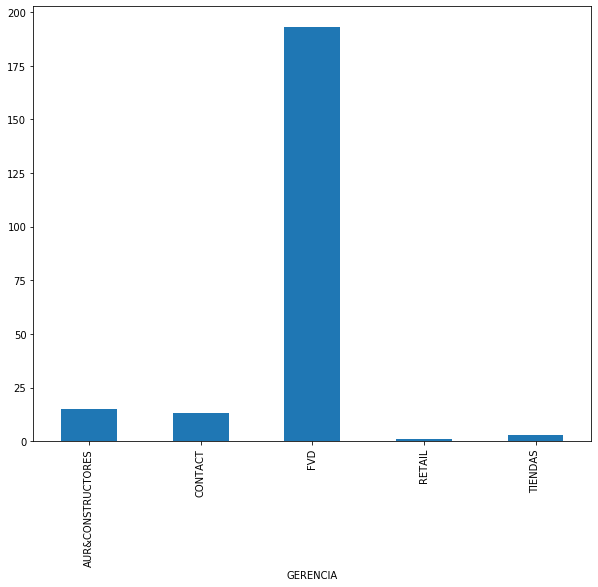

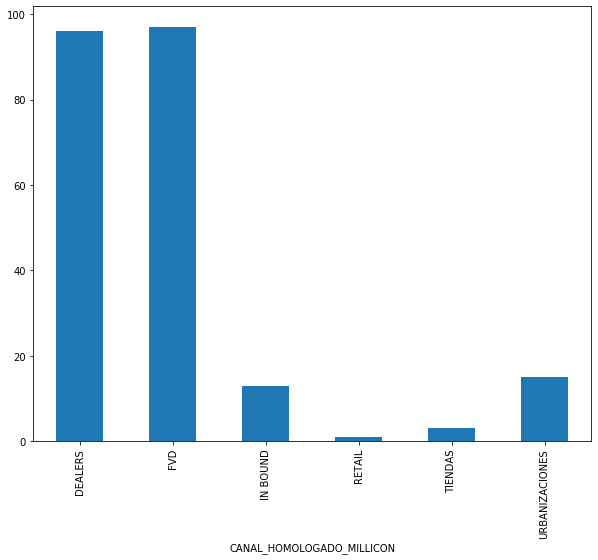

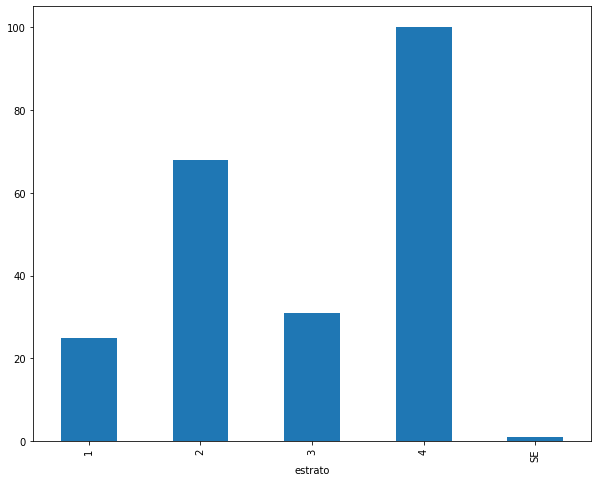

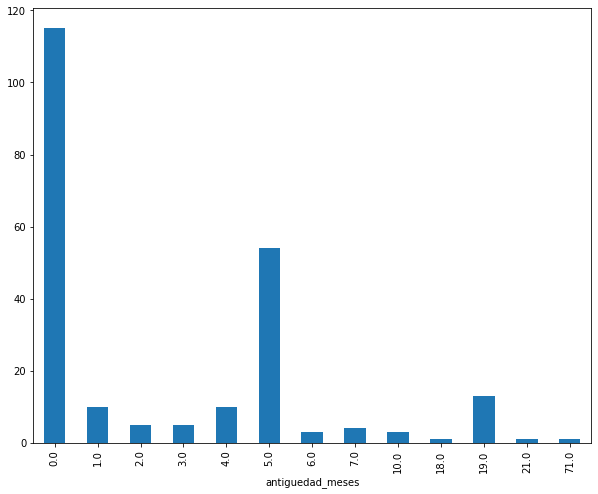

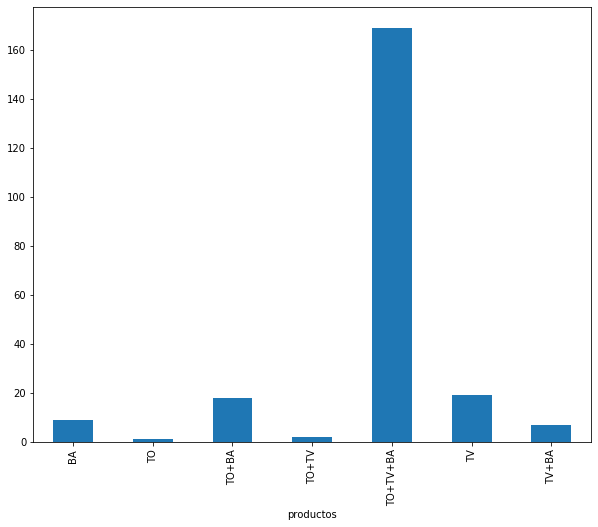

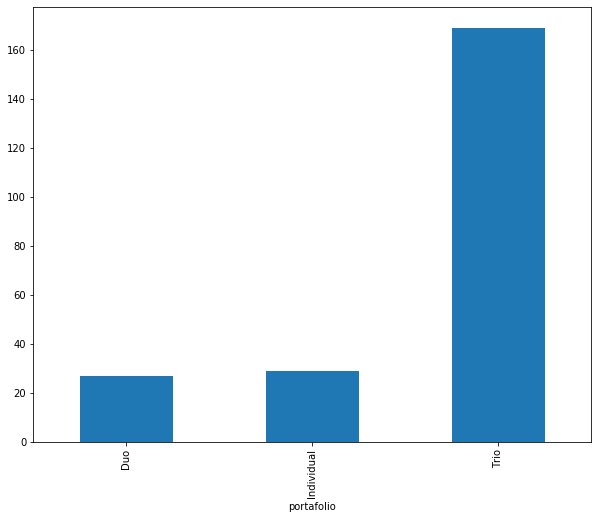

In [21]:
for columna in dfAltoRiesgo.drop(columns=['Incumplimiento_pago', 'cliente_id','fallo']).columns:
    fig,ax=plt.subplots(figsize=(10,8))
    dfAltoRiesgo.groupby(columna).size().plot(kind='bar',x=columna,ax=ax)

Los clientes con alto riesgo de no pago son clientes principalmente de la costa del país aunque también del Eje cafetero, auqnue la composición de departamentos a los cuales pertenecen es heterogénea. Muchos de ellos contratan  muchos productos y tienen todo el portafolio. En su mayoría pertenecen a estratos 2 y 4 y muy pocos tienen una alta antigüedad. 

La tecnología que tienen en verdad no parece ser determinante. Por su parte, el canal y la gerencia de venta si son sobresalientemente distintivos en este grupo.









## Sugerencias

Los servicios que tienen una mayor carga económica bruta, como presumiblemente son los paquetes de productos completos, deberían ser más restrictivos. Es decir, debería reducirse la base de clientes a quienes se les ofrece estos paquetes.

En vista de que la mayoría de clientes bienen del mismo canal y gerencia  de venta, se recomienda que las motivaciones a los vendedores y asesores digitales no solo estén relacionadas a las ventas sino también a las ventas de clientes de alto valor.

Como alternativa adicional, podrían establecerse políticas más estrictas en distintas regiones del país.

Ahora añadimos las información de las probabilidades a la base de datos original

In [22]:
datos_category=datos_category.merge(dataLearn[['cliente_id', 'probabilidadPago','probabilidadNoPago']], how='left', on='cliente_id')